# Semantic Parsing Final Project
Link to the paper: https://aclanthology.org/P16-1004.pdf

Read through the paper fully before starting the assignment!

In [ ]:
import torch
import torch.nn as nn

from google.colab import drive
drive.mount('/content/drive')

FILEPATH = "drive/MyDrive/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Downloading
This cell obtains the pre-processed Jobs dataset (see the paper) that you will be using to train and evaluate your model. (Pre-processed meaning that argument identification, section 3.6, has already been done for you). You should only need to run this cell ***once***. Feel free to delete it after running. Create a folder in your Google Drive in which the code below will store the pre-processed data needed for this project. Modify `FILEPATH` above to direct to said folder. It should start with `drive/MyDrive/...`, feel free to take a look at previous assignments that use mounting Google Drive if you can't remember what it should look like. *Make sure the data path ends with a slash character ('/').* The below code will access the zip file containing the pre-processed Jobs dataset from the paper and extract the files into your folder! Feel free to take a look at the `train.txt` and `test.txt` files to see what the data looks like. :)

In [ ]:
import requests
import io
import zipfile

# https://stackoverflow.com/questions/31126596/saving-response-from-requests-to-file
response = requests.get('http://dong.li/lang2logic/seq2seq_jobqueries.zip')
if response.status_code == 200:
  # https://stackoverflow.com/questions/3451111/unzipping-files-in-python
  with zipfile.ZipFile(io.BytesIO(response.content), "r") as zip_ref:
    zip_ref.extractall(FILEPATH)
  print("Extraction completed.")
else:
  print("Failed to download the zip file.")

Extraction completed.


# Data Pre-processing
The following code is defined for you! It extracts the queries (inputs to your Seq2Seq model) and logical forms (expected outputs) from the training and testing files. It also does important pre-processing such as padding the queries and logical forms and turns the words into vocab indices. **Look over and understand this code before you start the assignment!**

In [ ]:
def extract_file(filename):
  """
  Extracts queries and corresponding logical forms from either
  train.txt or test.txt. (Feel free to take a look at the files themselves
  in your Drive!)

  Parameters
  ----------
  filename : str
      name of the file to extract from

  Returns
  ----------
  tuple[list[list[str]], list[list[str]]]
      a tuple of a list of queries and their corresponding logical forms
      each in the form of a list of string tokens
  """
  queries, logical_forms = [], []
  with open(FILEPATH + filename) as f:
    for line in f:
      line = line.strip() # remove new line character
      query, logical_form = line.split('\t')

      query = query.split(' ')[::-1] # reversed inputs are used the paper (section 4.2)
      logical_form = ["<s>"] + logical_form.split(' ') + ["</s>"]

      queries.append(query)
      logical_forms.append(logical_form)
  return queries, logical_forms

query_train, lf_train = extract_file('train.txt') # 500 instances
query_test, lf_test = extract_file('test.txt') # 140 instances

In [ ]:
from collections import Counter

query_vocab = Counter()
for l in query_train:
  query_vocab.update(l)

query_word2idx = {}
for w, c in query_vocab.items():
  if c >= 2:
    query_word2idx[w] = len(query_word2idx)
query_word2idx['<UNK>'] = len(query_word2idx)
query_word2idx['<PAD>'] = len(query_word2idx)
query_idx2word = {i:word for word,i in query_word2idx.items()}

query_vocab = list(query_word2idx.keys())

lf_vocab = Counter()
for lf in lf_train:
  lf_vocab.update(lf)

lf_vocab['<UNK>'] = 0
lf_vocab['<PAD>'] = 0
lf_idx2word = {i:word for i, word in enumerate(lf_vocab.keys())}
lf_word2idx = {word:i for i, word in lf_idx2word.items()}

# print(list(query_word2idx.items())[:10]) # Now Quey stands for  input
# print(list(query_idx2word.items())[:10])

# print(list(lf_idx2word.items())[:10]) # Now LF stands for  output
# print(list(lf_idx2word.items())[:10])


In [ ]:
query_train_tokens = [[query_word2idx.get(w, query_word2idx['<UNK>']) for w in l] for l in query_train]
query_test_tokens = [[query_word2idx.get(w, query_word2idx['<UNK>']) for w in l] for l in query_test]

lf_train_tokens = [[lf_word2idx.get(w, lf_word2idx['<UNK>']) for w in l] for l in lf_train]
lf_test_tokens = [[lf_word2idx.get(w, lf_word2idx['<UNK>']) for w in l] for l in lf_test]

def pad(seq, max_len, pad_token_idx):
  """
  Pads a given sequence to the max length using the given padding token index

  Parameters
  ----------
  seq : list[int]
      sequence in the form of a list of vocab indices
  max_len : int
      length sequence should be padded to
  pad_token_idx
      vocabulary index of the padding token

  Returns
  ----------
  list[int]
      padded sequence
  """
  seq = seq[:max_len]
  padded_seq = seq + (max_len - len(seq)) * [pad_token_idx]
  return padded_seq

query_max_target_len = max([len(i) for i in query_train_tokens])
query_train_tokens = [pad(i, query_max_target_len, query_word2idx['<PAD>']) for i in query_train_tokens]
query_test_tokens = [pad(i, query_max_target_len, query_word2idx['<PAD>']) for i in query_test_tokens]

lf_max_target_len = int(max([len(i) for i in lf_train_tokens]) * 1.5)
lf_train_tokens = [pad(i, lf_max_target_len, lf_word2idx['<PAD>']) for i in lf_train_tokens]
lf_test_tokens = [pad(i, lf_max_target_len, lf_word2idx['<PAD>']) for i in lf_test_tokens]

# Data Loading
The following code creates a JobsDataset and DataLoaders to use with your implemented model. Take a look at the main function at the end of this stencil to see how they are used in context.

In [ ]:
from torch.utils.data import Dataset, DataLoader, default_collate

class JobsDataset(Dataset):
  """Defines a Dataset object for the Jobs dataset to be used with Dataloader"""
  def __init__(self, queries, logical_forms):
    """
    Initializes a JobsDataset

    Parameters
    ----------
    queries : list[list[int]]
        a list of queries, which have been tokenized and padded, in the form
        of a list of vocab indices
    logical_forms : list[list[int]]
        a list of corresponding logical forms, which have been tokenized and
        padded, in the form of a list of vocab indices
    """
    self.queries = queries
    self.logical_forms = logical_forms

  def __len__(self) -> int:
    """
    Returns the amount of paired queries and logical forms in the dataset

    Returns
    ----------
    int
        length of the dataset
    """
    return len(self.queries)

  def __getitem__(self, idx: int) -> tuple[list[int], list[int]]:
    """
    Returns a paired query and logical form at the specified index

    Parameters
    ----------
    idx : int
        specified index of the dataset

    Returns
    ----------
    tuple[list[int], list[int]]
        paired query and logical form at the specified index, in the form of
        a list of vocab indices
    """
    return self.queries[idx], self.logical_forms[idx]

def build_datasets() -> tuple[JobsDataset, JobsDataset]:
  """
  Builds a train and a test dataset from the queries and logical forms
  train and test tokens

  Returns
  ----------
  tuple[JobsDataset, JobsDataset]
      a training and testing JobsDataset
  """
  jobs_train = JobsDataset(queries=query_train_tokens, logical_forms=lf_train_tokens)
  jobs_test = JobsDataset(queries=query_test_tokens, logical_forms=lf_test_tokens)
  return jobs_train, jobs_test

def collate(batch : list[tuple[list[int], list[int]]]) -> tuple[torch.Tensor, torch.Tensor]:
  """
  Used as collate_fn when creating the Dataloaders from the dataset

  Parameters
  ----------
  batch : list[tuple[list[int], list[int]]]
      a list of outputs of __getitem__

  Returns
  ----------
  tuple[torch.Tensor, torch.Tensor]
      a batched set of input sequences and a batched set of target sequences
  """
  src, tgt = default_collate(batch)
  return torch.stack(src), torch.stack(tgt)

def build_dataloaders(dataset_train: JobsDataset, dataset_test: JobsDataset,
                      train_batch_size: int) -> tuple[DataLoader, DataLoader]:
  """
  Used as collate_fn when creating the Dataloaders from the dataset, batching
  the training data according to the inputted batch size and batching the
  testing data with a batch size of 1

  Parameters
  ----------
  dataset_train : JobsDataset
      training dataset
  dataset_test : JobsDataset
      testing dataset
  train_batch_size : int
      batch size to be used during training

  Returns
  ----------
  tuple[DataLoader, DataLoader]
      a training and testing DataLoader
  """
  dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True, collate_fn=collate)
  dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate)
  return dataloader_train, dataloader_test

# See the dataloader Now!

In [ ]:
# 1. load set
jobs_train, jobs_test = build_datasets()

# 2. create DataLoader
train_dataloader, test_dataloader = build_dataloaders(jobs_train, jobs_test, train_batch_size=20)

# 3. print DataLoader content
print("Printing a few samples from the train DataLoader:")
for i, (queries, logical_forms) in enumerate(train_dataloader):
    print(f"Batch {i+1}:")
    print(f"Queries Shape (Input): {queries.shape}")
    print(f"Logical Forms Shape (Target): {logical_forms.shape}")
    break  # print only first batch

# iterate DataLoader first few batch
for i, (queries, logical_forms) in enumerate(train_dataloader):
    print(f"Batch {i+1}:")
    print(f"Queries: {queries}")
    print(f"Logical Forms: {logical_forms}")

    break

for i, (queries, logical_forms) in enumerate(train_dataloader):
    print(f"Batch {i+1}:")
    print(f"Queries (Input): {queries}")
    print(f"Logical Forms (Target): {logical_forms}")
    break  # print one batch



Printing a few samples from the train DataLoader:
Batch 1:
Queries Shape (Input): torch.Size([20, 20])
Logical Forms Shape (Target): torch.Size([64, 20])
Batch 1:
Queries: tensor([[ 11,  39,   9,  11,  25,  13,  25,   7,  42,  13,  15,  75,  27,  11,
          13,  13,  25,   7,  15,  84],
        [ 12,  31,  11,  12,  14,  33,   4,  86, 124,  33,  16,  13,  41,  17,
          33,  14,  54,  27, 124,  89],
        [ 15, 124,  24,   2,  35,  14,  84,  63,  41,  14,  39,  33,  53,  12,
          63,   9,  63,  18,  63,  18],
        [ 16,  17,   2,  20,   2,  11, 122,  13,  33,  11,  59,  14,  42,  18,
          25,  17,  13,  22,  11, 100],
        [ 18,  20,  20,   9,  20,  12,  57,  33,  38,  12,   7,  39,  61,  93,
          54,   5,  33,  28,  12, 101],
        [  4,  21, 125,   3,   9,   7,  92,  91,   9,   7,   8,  44,   9,  19,
          14,  29,  14, 125,  23,  19],
        [ 26,  63, 125, 125,  34,   8,  25,  44,   3,   8,   9,   9,  21,  38,
          39, 125,   9, 125,   3,  

# Import: Import all packages that I might used here!





In [ ]:
import torch.nn as nn
import random
from torch import optim
from timeit import default_timer as timer
from torch.optim import RMSprop
from torch.optim.lr_scheduler import StepLR

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from timeit import default_timer as timer

### **Implemented Equations**
This section contains important equations for the implementation, this markfown is used as a reminder. They are not 100% the same as the equation used in the paper
#### Sequence-to-Sequence Model(Section 3.1)

The encoder and decoder are two different L-layer recurrent neural
networks with long short-term memory (LSTM) units which recursively process tokens one by one.

1. **LSTM Representation** (Section 3.1, equation 2):
   Let $h_l∈ \mathbf{R_n}$ denote the hidden vector at time step t and layer l. $h^l_t$ is then computed by:
    \begin{align}
   h^l_t = \text{LSTM}(h^{l-1}_t, h^l_{t-1})
    \end{align}
   


2. **Model Output** (Section 3.1, equation 1):

  Seq2Seq maps natural language input $q = x_1 \dots x_{|q|}$ to a logical form representation of its meaning $a = y_1 \dots y_{|a|}$.
   $$
   p(a|q) = \prod_{t=1}^{|a|} p(y_t | y_{<t}, q)
   $$
   where $ y_{<t} = y_1 \dots y_{t-1} $

3. **Predict t-th token output** (Section 3.1, equation 3)
$$ p (y_t|y_{<t}, q) = softmax(W_oh^L_t)^T|e(y_t)$$
---

#### Attention Mechanism (Section 3.3)
2. **Attention Scores** (Section 3.3, equation 5):
   $$
   s^t_k = \frac{\exp(h^L_t \cdot h^L_k)}{\sum_{j=1}^{|q|} \exp(h^L_t \cdot h^L_j)}
   $$
   Here, $ s^t_k $ represents the attention score for the $ k $-th encoder hidden state $ h^L_k $ relative to the decoder hidden state $ h^L_t $.

3. **Context Vector** (Section 3.3, equation 6):
   $$
   c^t = \sum_{k=1}^{|q|} s^t_k \cdot h^L_k
   $$
   The context vector $ c^t $ summarizes relevant information from the encoder hidden states $ h^L_k $.

4. **Combined Representation** (Section 3.3, equation 7):
   $$
   h^{att}_t = \tanh(W_1 h^L_t + W_2 c^t)
   $$
   Here, $ h^{att}_t $ is the combined representation of the decoder hidden state $ h^L_t $ and the context vector $ c^t $.

5. **Improved equation 3 using attention** (Section 3.3, equation 8)
$$p (y_t|y_{<t}, q) = softmax(W_oh^{att}_t)^T|e(y_t)$$

# TODO: Define your model here!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from timeit import default_timer as timer

QUERY_VOCAB_LEN = len(query_vocab)  # Input vocabulary size
LF_VOCAB_LEN = len(lf_vocab)  # Output vocabulary size
emb_dim = 128  # Embedding dimension
hid_dim = 256  # Hidden state dimension for LSTM
n_layers = 2  # Number of LSTM layers
device = "cuda" if torch.cuda.is_available() else "cpu"

class Attention(nn.Module):
    def __init__(self, hid_dim: int = 256, output_dim: int = LF_VOCAB_LEN):
        super().__init__()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=0)
        self.w0 = nn.Linear(hid_dim, output_dim)  # Final output
        self.w1 = nn.Linear(hid_dim, hid_dim)
        self.w2 = nn.Linear(hid_dim, hid_dim)

    def forward(self, hidden: torch.FloatTensor, enc_outputs: torch.FloatTensor, dec_outputs: torch.FloatTensor):
        """
        Attention mechanism to compute context vector.
        Attention mechanism to compute context vector.
        - Equation (5): Compute attention scores using dot product
        - Equation (6): Compute context vector as weighted sum of encoder hidden states
        - Equation (7): Combine context vector with decoder hidden state

        """
        # Equation (7): Final attention-based using tanh(W1hLt+W2ct)
        return self.w0(self.tanh(
            self.w1(dec_outputs)
             + self.w2(
                 torch.sum(self.softmax(enc_outputs * hidden[-1]) # softmax for equation [5]
                 * enc_outputs, dim=0) ))) # Sum to compute context vector for equation [6]



class Seq2Seq(nn.Module):
    """
    Seq2Seq model combining Encoder, Decoder, and Attention modules.
    """

    class Encoder(nn.Module):
        def __init__(self, input_dim: int, emb_dim: int, hid_dim: int, n_layers: int):
            super().__init__()
            # Define a two layer lstm, fetch hidden using hidden[0], hidden[1], cell[0],cell[1]
            # Equation (2): Encode input sequence into hidden vectors

            self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=n_layers)
            # According to rubric, use nn.Embedding
            self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)

        def forward(self, enc_input: torch.Tensor) -> dict:
            # h^0_t = Wq * e(x_t) (Equation in text)
            embedding = self.embedding(enc_input)
            # Use a state_dict to store returned info and manage data
            outputs, (hidden, cell) = self.lstm(embedding)
            # Hidden states used to initialize decoder
            return {"outputs": outputs, "hidden": hidden, "cell": cell}

    class Decoder(nn.Module):
        def __init__(self, output_dim: int, emb_dim: int, hid_dim: int, n_layers: int):
            super().__init__()
            # Define a two layer lstm, fetch hidden using hidden[0], hidden[1], cell[0],cell[1]
            # Equation (3): Decode the t-th token based on top-layer hidden state

            self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=n_layers)
            # According to rubric, use nn.Embedding
            self.embedding = nn.Embedding(num_embeddings=output_dim, embedding_dim=emb_dim)

        def forward(self, dec_input: torch.Tensor, state_dict: dict) -> dict:
            # h^0_t = Wa * e(y_t-1) (Equation in text)
            embedding = self.embedding(dec_input)
            # Read state_dict passed from encoder, in this case, we use hidden output to initialize decoder!
            outputs, (hidden, cell) = self.lstm(embedding, (state_dict["hidden"], state_dict["cell"]))
            state_dict["outputs"] = outputs
            state_dict["hidden"] = hidden
            state_dict["cell"] = cell
            return state_dict

    def __init__(self, device: str, input_dim: int, output_dim: int, emb_dim: int, hid_dim: int, n_layers: int):
        super().__init__()
        self.encoder = self.Encoder(input_dim, emb_dim, hid_dim, n_layers).to(device)
        self.decoder = self.Decoder(output_dim, emb_dim, hid_dim, n_layers).to(device)
        self.attention = Attention(hid_dim=hid_dim, output_dim=output_dim).to(device)
        self.device = device

        # Loss function and optimizer
        self.criterion = nn.NLLLoss(ignore_index=lf_word2idx["<PAD>"])
        self.optimizer = optim.RMSprop(self.parameters(), lr=0.001)

    def get_loss(self):
        return self.criterion

    def get_optimizer(self):
        return self.optimizer

    def forward(self, input_batch: torch.Tensor, query_batch: torch.Tensor, teacher_forcing_ratio: float = 1.0) -> torch.Tensor:
        # implemented Equations (1)-(3) and (5)-(7) in the paper

        query_size, batch_size = query_batch.shape
        query_vocab_size = self.decoder.embedding.num_embeddings
        outputs = torch.zeros(query_size, batch_size, query_vocab_size).to(self.device)

        # Encoder forward pass (Equations (1)-(2))

        state_dict_enc = self.encoder(input_batch)
        enc_outputs, hidden, cell = state_dict_enc["outputs"], state_dict_enc["hidden"], state_dict_enc["cell"]

        # Initialize decoder with encoder states and start decoding with <SOS> token
        query = query_batch[0].unsqueeze(0)

        for i in range(1, query_size):
            state_dict_dec = self.decoder(query, state_dict_enc) # in this case, we use hidden output for encoder to initialize decoder!
            # Attention uses equation [5]-[7]
            outputs[i] = self.attention(state_dict_dec["hidden"], enc_outputs, state_dict_dec["outputs"])
            # Prediction step: Softmax over logits (Equation (8))
            best_pred = torch.argmax(outputs[i], dim=-1)


            # Equation (3): Predict next token
            if teacher_forcing_ratio == 1.0: # Training and Use ground truth
                query = query_batch[i].unsqueeze(0)
            else: # Testing and  Use model's prediction
                query = best_pred.unsqueeze(0)

        return outputs


# Model creation function
def create_model():
    return Seq2Seq(
        device=device,
        input_dim=QUERY_VOCAB_LEN,
        output_dim=LF_VOCAB_LEN,
        emb_dim=emb_dim,
        hid_dim=hid_dim,
        n_layers=n_layers,
    )


In [ ]:
# Example code to traverse one batch and print intermediate outputs
jobs_train, jobs_test = build_datasets()

# 2. create DataLoader
train_dataloader, test_dataloader = build_dataloaders(jobs_train, jobs_test, train_batch_size=20)
seq2seq_model = create_model()
print(seq2seq_model)
# Load one batch from DataLoader
for i, (queries, logical_forms) in enumerate(train_dataloader):
    print(f"Batch {i+1}:")
    print(f"Queries Shape (Input): {queries.shape}")
    print(f"Logical Forms Shape (Target): {logical_forms.shape}")

    # Move batch to the appropriate device
    queries = queries.to(device)
    logical_forms = logical_forms.to(device)

    # Pass batch through Seq2Seq model
    seq2seq_model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        state_dict_enc = seq2seq_model.encoder(queries)
        enc_outputs, hidden, cell = state_dict_enc["outputs"], state_dict_enc["hidden"], state_dict_enc["cell"]

        print("\nEncoder Outputs:")
        print(f"Encoder Outputs Shape: {enc_outputs.shape}")
        print(f"Hidden State Shape: {hidden.shape}")
        print(f"Cell State Shape: {cell.shape}")

        # Decoder Initialization
        query = logical_forms[0].unsqueeze(0)  # <SOS> token
        state_dict_dec = seq2seq_model.decoder(query, state_dict_enc)

        print("\nDecoder Initialization:")
        print(f"Decoder Outputs Shape: {state_dict_dec['outputs'].shape}")
        print(f"Hidden State Shape: {state_dict_dec['hidden'].shape}")
        print(f"Cell State Shape: {state_dict_dec['cell'].shape}")

        # Compute Attention
        attention_scores = seq2seq_model.attention(state_dict_dec["hidden"], enc_outputs, state_dict_dec["outputs"])
        print("\nAttention Mechanism:")
        print(f"Attention Scores Shape: {attention_scores.shape}")

    break  # Process only one batch for visualization purposes


Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(128, 256, num_layers=2)
    (embedding): Embedding(126, 128)
  )
  (decoder): Decoder(
    (lstm): LSTM(128, 256, num_layers=2)
    (embedding): Embedding(52, 128)
  )
  (attention): Attention(
    (tanh): Tanh()
    (softmax): Softmax(dim=0)
    (w0): Linear(in_features=256, out_features=52, bias=True)
    (w1): Linear(in_features=256, out_features=256, bias=True)
    (w2): Linear(in_features=256, out_features=256, bias=True)
  )
  (criterion): NLLLoss()
)
Batch 1:
Queries Shape (Input): torch.Size([20, 20])
Logical Forms Shape (Target): torch.Size([64, 20])

Encoder Outputs:
Encoder Outputs Shape: torch.Size([20, 20, 256])
Hidden State Shape: torch.Size([2, 20, 256])
Cell State Shape: torch.Size([2, 20, 256])

Decoder Initialization:
Decoder Outputs Shape: torch.Size([1, 20, 256])
Hidden State Shape: torch.Size([2, 20, 256])
Cell State Shape: torch.Size([2, 20, 256])

Attention Mechanism:
Attention Scores Shape: torch.Size([1, 20, 52])


# TODO: Training and testing loops

In [ ]:
LF_SOS_INDEX = lf_word2idx['<s>']
LF_EOS_INDEX = lf_word2idx['</s>']
LF_PAD_INDEX = lf_word2idx['<PAD>']

In [ ]:
print(LF_SOS_INDEX, LF_EOS_INDEX, LF_PAD_INDEX)

0 5 51


### **Trainer**
We adopt torch.nn.NLLLoss and the RMSProp optimzier according to the paper section 3.4


In [ ]:
def train(model: nn.Module, train_dataloader: DataLoader, num_epochs: int = 5,
          device: str = "cuda") -> nn.Module:
    """
    Trains a given model on the provided DataLoader using RMSProp and NLLLoss.

    Parameters
    ----------
    model : nn.Module
        The Seq2Seq model to train.
    train_dataloader : DataLoader
        DataLoader containing the training dataset.
    num_epochs : int
        Number of epochs to train the model.
    device : str
        Device to run the training on ("cuda" or "cpu").

    Returns
    ----------
    nn.Module
        The trained model.
    """
    # Define the loss function
    criterion = model.get_loss()
    optimizer = model.get_optimizer()

    # Add a scheduler for dynamic learning rate adjustment
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Halve LR every 2 epochs
    # Move the model to the appropriate device
    model = model.to(device)
    model.train()  # Set the model to training mode

    for epoch in range(0, num_epochs):
        epoch_loss = 0
        start_time = timer()

        for queries, logical_forms in train_dataloader:
            # Move data to device
            queries = queries.to(device)
            logical_forms = logical_forms.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(queries, logical_forms, 1.0)

            # Compute log probabilities for NLLLoss
            log_probs = outputs.log_softmax(dim=-1)

            # Reshape outputs and targets for loss computation
            log_probs = log_probs.view(-1, log_probs.size(-1))  # [seq_len * batch_size, output_dim]
            targets = logical_forms.view(-1)                   # [seq_len * batch_size]

            # Compute loss
            loss = criterion(log_probs, targets)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += loss.item()
        end_time = timer()

        # Print epoch loss
        train_loss = epoch_loss / len(train_dataloader)
        print((f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    print("Training completed!")
    return model


### **Inference**

We adopt the greedy decoding method, using equation 10 $$â = argmax_{a'} p(a'|q) $$

In [ ]:


def evaluate(model: nn.Module, dataloader: DataLoader, device: str = "cuda") -> tuple[int, int]:
    """
    Evaluates the model on the provided DataLoader using greedy decoding.

    Parameters
    ----------
    model : nn.Module
        The trained Seq2Seq model.
    dataloader : DataLoader
        DataLoader containing evaluation data.
    device : str
        Device to run the evaluation on ("cuda" or "cpu").

    Returns
    ----------
    tuple
        Per-token accuracy and exact-match accuracy.
    """
    # Initialize metrics as a dictionary
    metrics = {
        "per_token_count": 0,
        "per_token_total": 0,
        "exact_match_count": 0,
        "total_sequences": 0,
    }
    teacher_forcing = 0.0  # Disabled for evaluation

    model.eval()
    with torch.no_grad():
        for input, query in dataloader:
            preds = []
            truth = []
            exact_match_flag = True  # For exact-match accuracy

            # Move data to the device
            input, query = input.to(device), query.to(device)

            # Forward pass with teacher forcing disabled
            logits = model(input, query, teacher_forcing_ratio=teacher_forcing)
            pred = torch.argmax(logits, dim=-1)  # Get predictions
            flattened_pred = pred.view(-1)
            flattened_query = query.view(-1)
            # for p, q in zip(pred[1:].squeeze(), query[1:].squeeze()):
            for p, q in zip(flattened_pred, flattened_query):
                if q.item() != LF_EOS_INDEX and p != q:
                    exact_match_flag = False  # Mark sequence as incorrect if one token mismatches

                if q.item() == LF_EOS_INDEX:  # Stop when <EOS> is encountered
                    break

                if p == q:  # Token matches
                    metrics["per_token_count"] += 1

                metrics["per_token_total"] += 1

                preds.append(query_idx2word[p.item()])
                truth.append(query_idx2word[q.item()])

            # Update exact match count if the sequence matches entirely
            if exact_match_flag:
                metrics["exact_match_count"] += 1

            # Increment total sequences
            metrics["total_sequences"] += 1

    # Compute accuracies
    per_token_acc = metrics["per_token_count"] / metrics["per_token_total"] if metrics["per_token_total"] > 0 else 0.0
    exact_match_acc = metrics["exact_match_count"] / metrics["total_sequences"] if metrics["total_sequences"] > 0 else 0.0

    print(f"Per-token Accuracy: {per_token_acc:.4f}")
    print(f"Exact-match Accuracy: {exact_match_acc:.4f}")

    return per_token_acc, exact_match_acc


# Run this!

Running for seed: 52
Epoch: 1, Train loss: 2.007, Epoch time = 4.463s
Epoch: 2, Train loss: 0.916, Epoch time = 4.181s
Epoch: 3, Train loss: 0.803, Epoch time = 3.659s
Epoch: 4, Train loss: 0.697, Epoch time = 3.755s
Epoch: 5, Train loss: 0.615, Epoch time = 4.705s
Epoch: 6, Train loss: 0.550, Epoch time = 3.661s
Epoch: 7, Train loss: 0.508, Epoch time = 3.720s
Epoch: 8, Train loss: 0.467, Epoch time = 4.803s
Epoch: 9, Train loss: 0.427, Epoch time = 3.682s
Epoch: 10, Train loss: 0.398, Epoch time = 3.685s
Epoch: 11, Train loss: 0.377, Epoch time = 4.488s
Epoch: 12, Train loss: 0.350, Epoch time = 4.040s
Epoch: 13, Train loss: 0.320, Epoch time = 3.638s
Epoch: 14, Train loss: 0.315, Epoch time = 3.823s
Epoch: 15, Train loss: 0.283, Epoch time = 4.619s
Epoch: 16, Train loss: 0.269, Epoch time = 3.660s
Epoch: 17, Train loss: 0.266, Epoch time = 3.705s
Epoch: 18, Train loss: 0.282, Epoch time = 4.812s
Epoch: 19, Train loss: 0.247, Epoch time = 3.684s
Epoch: 20, Train loss: 0.236, Epoch ti

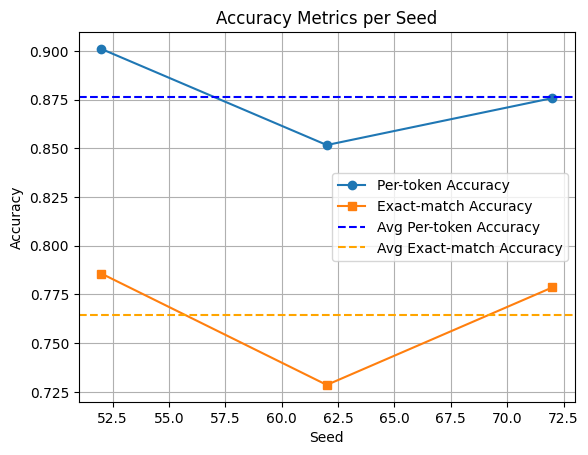

In [ ]:
import torch
import matplotlib.pyplot as plt

def run_experiment(seeds, train_batch_size=20, num_epochs=20):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    per_token_accuracies = []
    exact_match_accuracies = []

    for seed in seeds:
        print(f"Running for seed: {seed}")
        # Set seed for reproducibility
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        # Initialize datasets and dataloaders
        jobs_train, jobs_test = build_datasets()
        dataloader_train, dataloader_test = build_dataloaders(jobs_train, jobs_test, train_batch_size=train_batch_size)

        # Create and train the model
        model = create_model()
        model = train(model, dataloader_train, num_epochs=num_epochs, device=device)

        # Evaluate the model
        test_per_token_accuracy, test_exact_match_accuracy = evaluate(model, dataloader_test, device=device)

        # Store the results
        per_token_accuracies.append(test_per_token_accuracy)
        exact_match_accuracies.append(test_exact_match_accuracy)

        print(f"Seed {seed}: Test Per-token Accuracy = {test_per_token_accuracy:.4f}, "
              f"Test Exact-match Accuracy = {test_exact_match_accuracy:.4f}")

    # Compute averages
    avg_per_token_accuracy = sum(per_token_accuracies) / len(seeds)
    avg_exact_match_accuracy = sum(exact_match_accuracies) / len(seeds)

    # Print average results
    print(f"Average Per-token Accuracy over seeds {seeds}: {avg_per_token_accuracy:.4f}")
    print(f"Average Exact-match Accuracy over seeds {seeds}: {avg_exact_match_accuracy:.4f}")

    # Plot results
    plt.figure()
    plt.plot(seeds, per_token_accuracies, marker='o', label='Per-token Accuracy')
    plt.plot(seeds, exact_match_accuracies, marker='s', label='Exact-match Accuracy')
    plt.axhline(y=avg_per_token_accuracy, color='blue', linestyle='--', label='Avg Per-token Accuracy')
    plt.axhline(y=avg_exact_match_accuracy, color='orange', linestyle='--', label='Avg Exact-match Accuracy')
    plt.xlabel("Seed")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Metrics per Seed")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
seeds = [52, 62, 72]
run_experiment(seeds)


In [ ]:
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    jobs_train, jobs_test = build_datasets()
    dataloader_train, dataloader_test = build_dataloaders(jobs_train, jobs_test, train_batch_size=20)
    model = create_model()
    model = train(model, dataloader_train, num_epochs=20, device=device)
    test_per_token_accuracy, test_exact_match_accuracy = evaluate(model, dataloader_test, device=device)
    print(f'Test Per-token Accuracy: {test_per_token_accuracy}')
    print(f'Test Exact-match Accuracy: {test_exact_match_accuracy}')
main()

Epoch: 1, Train loss: 1.953, Epoch time = 3.647s
Epoch: 2, Train loss: 0.879, Epoch time = 3.811s
Epoch: 3, Train loss: 0.715, Epoch time = 4.617s
Epoch: 4, Train loss: 0.605, Epoch time = 3.667s
Epoch: 5, Train loss: 0.520, Epoch time = 3.661s
Epoch: 6, Train loss: 0.455, Epoch time = 4.796s
Epoch: 7, Train loss: 0.412, Epoch time = 3.715s
Epoch: 8, Train loss: 0.382, Epoch time = 3.672s
Epoch: 9, Train loss: 0.352, Epoch time = 4.484s
Epoch: 10, Train loss: 0.325, Epoch time = 3.913s
Epoch: 11, Train loss: 0.315, Epoch time = 3.697s
Epoch: 12, Train loss: 0.293, Epoch time = 3.941s
Epoch: 13, Train loss: 0.275, Epoch time = 4.487s
Epoch: 14, Train loss: 0.267, Epoch time = 3.817s
Epoch: 15, Train loss: 0.261, Epoch time = 3.697s
Epoch: 16, Train loss: 0.243, Epoch time = 4.890s
Epoch: 17, Train loss: 0.234, Epoch time = 3.833s
Epoch: 18, Train loss: 0.226, Epoch time = 3.726s
Epoch: 19, Train loss: 0.265, Epoch time = 4.859s
Epoch: 20, Train loss: 0.231, Epoch time = 3.715s
Training 